In [29]:
from openai import OpenAI
import base64
import json
from pathlib import Path
import os
from PIL import Image
from matplotlib import pyplot as plt
from io import BytesIO
import json
from pydantic import BaseModel
import pprint as pp
import numpy as np

In [ ]:
# Function to open image file, resize to 512x512, and encode to base64


def encode_image(image_path):
    image = Image.open(image_path)
    # image = image.resize((512, 512))
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str
    

In [93]:

def get_b64_images(img_dir_path):
    files = os.listdir(img_dir_path)
    # sort the files by filename
    files.sort()
    #files = files[:10]
    # read each file, convert to base64 and put in an array
    images = []
    images_b64 = []
    for file in files:
        if file.endswith(".png"):
            # store the images as a PIL image in the array
            image = Image.open(os.path.join(img_dir_path, file))
            images.append(image)
            images_b64.append(encode_image(os.path.join(img_dir_path, file)))
    return images, images_b64


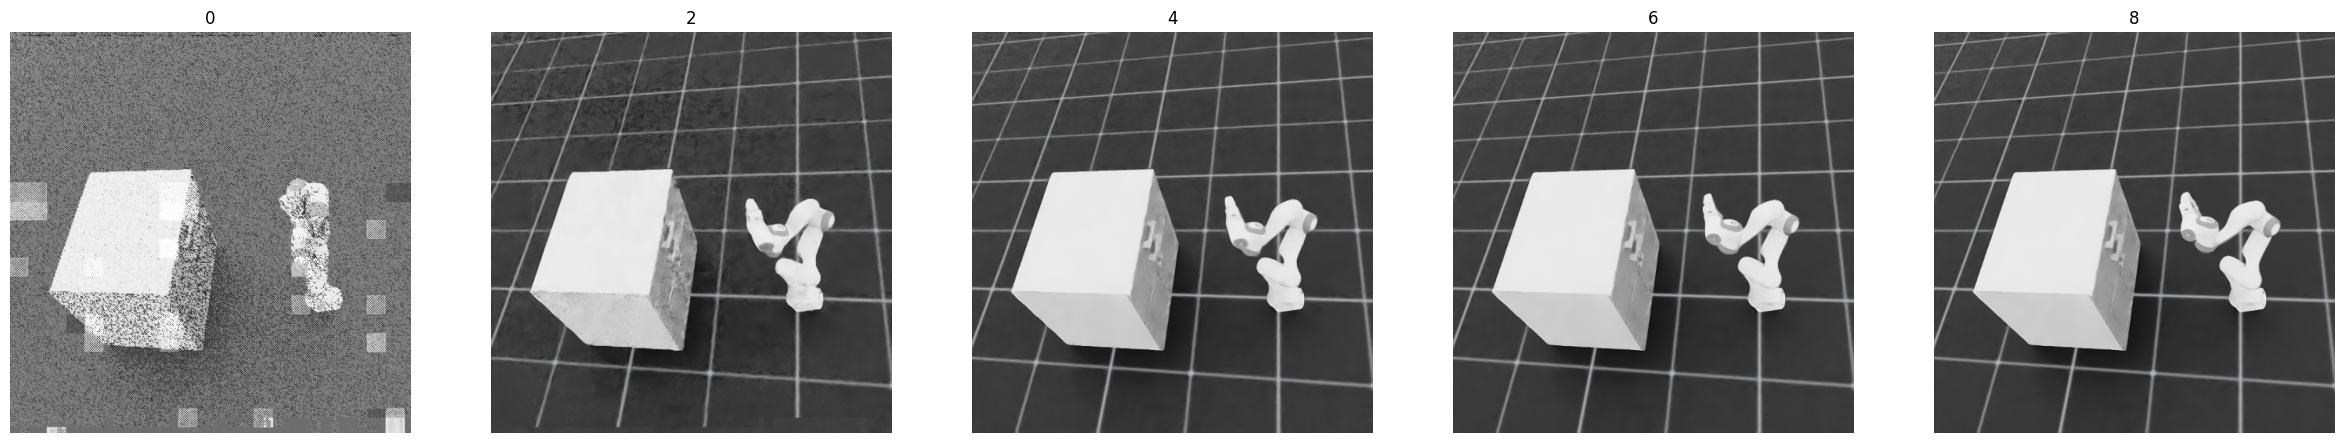

In [86]:
# plot the images in a single plot using matplotlib
img_plot_idx = list(range(0,10,2))
images_sub = [image for i, image in enumerate(images) if i in img_plot_idx]
fig, axs = plt.subplots(1, len(images_sub), figsize=(30, 30))
for i, image in enumerate(images_sub):
    axs[i].imshow(image)
    axs[i].axis("off")
    axs[i].set_title(img_plot_idx[i])

In [94]:
def get_gpt_message(ref_image_b64, eval_image_b64):
    message = [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": """You are an image assessment tool that intreprets images and provides a real valued score between 0 and 10, indicating the degree that a robot has completed a specified task. 
                    A score of 0 is assigned in the initial state, and a score of 10 is assigned in the final state when the task is completed.""",
                },                   
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "A robot arm is given a task to open the top drawer of a white cabinet.",
                },          
                {
                    "type": "text",
                    "text": "A reference image of the initial state of the task is shown in the following image. The score for the reference image is 0"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{ref_image_b64}",
                        "detail": "auto",
                        },
                },
                {
                    "type": "text",
                    "text": "Provide a score for the following image.",
                },         
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{eval_image_b64}",
                        "detail": "auto",
                        },
                },
            ],
        },
    ]
    return message


In [20]:
class Score(BaseModel):
    score: float

class GPT_Rewards(BaseModel):
    scores: list[Score]

In [95]:

def get_gpt_rewards(images_b64, sample_period=30):
    api_key = os.environ.get("OPENAIKEY")
    gpt_client = OpenAI(
        api_key=api_key
    )
    gpt_rew = np.zeros(len(images_b64))
    # get a reward score for each of the evaluation images
    for i in range(sample_period-10, len(images_b64), sample_period):
        #print(f"Evaluating image: {i}")
        eval_image_b64 = images_b64[i]
        message = get_gpt_message(ref_image_b64, eval_image_b64)
        response = gpt_client.chat.completions.create(
            model="gpt-4o-2024-08-06",
            messages=message,
            response_format={
                'type': 'json_schema',
                'json_schema':
                    {
                        "name": "whocares",
                        "schema": GPT_Rewards.model_json_schema()
                    }
            }
        )
        reward_scores = response.choices[0].message.content
        reward_array = json.loads(reward_scores)["scores"]
        score_array = [score["score"] for score in reward_array]
        gpt_rew[i] = score_array[0]
    return gpt_rew


In [103]:
# compute rewards for p1
point = "p1"
image_path = f"/home/levi/projects/IsaacLab/source/vlmrew/dev_images/" + point
images, images_b64 = get_b64_images(image_path)
gpt_rew = get_gpt_rewards(images_b64, sample_period=30)

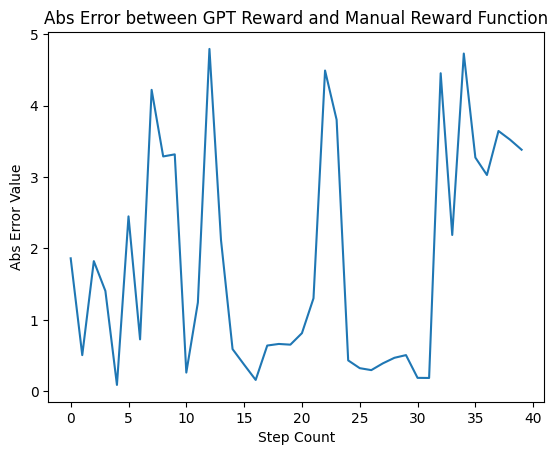

In [104]:
# Get the error between the manual reward and the GPT reward for all gpt values above 0
error_list = [np.abs(gpt_rew[i]-man_rew_norm[i-1]) for i in range(len(gpt_rew)) if gpt_rew[i] > 0]


# plot the error list
plt.plot(error_list)
plt.xlabel("Step Count")
plt.ylabel("Abs Error Value")
plt.title("Abs Error between GPT Reward and Manual Reward Function")
plt.show()

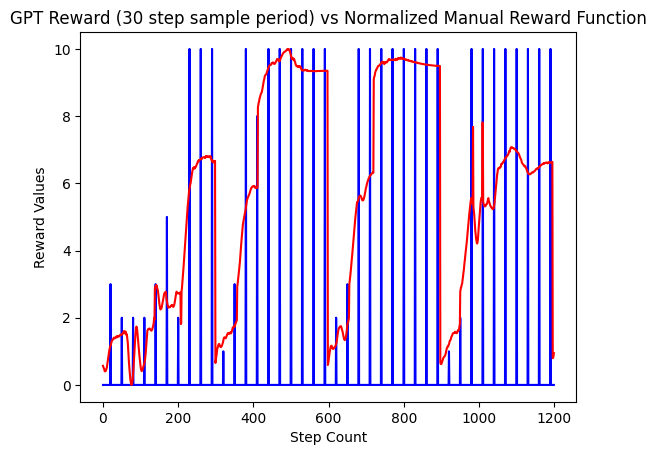

In [106]:
# Read in the rewards pickle file
import pickle
rewards = pickle.load(open("/home/levi/projects/IsaacLab/source/vlmrew/franka_cabinet/logs/manual_rewards.pkl", "rb"))

# scale the rewards data from 0 to 10
man_rew_norm = (rewards - np.min(rewards)) / (np.max(rewards) - np.min(rewards)) * 10
# plot the rewards
plt.plot(gpt_rew, 'b')
plt.plot(man_rew_norm, 'r')
plt.xlabel("Step Count")
plt.ylabel("Reward Values")
plt.title("GPT Reward (30 step sample period) vs Normalized Manual Reward Function")
plt.show()

In [96]:

points = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10']
aspect_mse_array = np.zeros(len(points))

for j, point in enumerate(points):
    print(f"Calculating error for {point}")
    # get the index of the point    
    image_path = f"/home/levi/projects/IsaacLab/source/vlmrew/dev_images/" + point
    images, images_b64 = get_b64_images(image_path)
    gpt_rew = get_gpt_rewards(images_b64, sample_period=30)

    error_list = [np.abs(gpt_rew[i]-man_rew_norm[i-1]) for i in range(len(gpt_rew)) if gpt_rew[i] > 0]
    aspect_mse_array[j] = np.mean(np.square(np.array(error_list)))

Calculating error for p1
Calculating error for p2
Calculating error for p3
Calculating error for p4
Calculating error for p5
Calculating error for p6
Calculating error for p7
Calculating error for p8
Calculating error for p9
Calculating error for p10


In [100]:
# save the aspect_mse_array to a pkl file
aspect_mse_file_path = "/home/levi/projects/IsaacLab/source/vlmrew/franka_cabinet/logs/aspect_mse_array.pkl"
pickle.dump(aspect_mse_array, open(aspect_mse_file_path, "wb"))

In [101]:
# read the aspect_mse_array from the pkl file
aspect_mse_array = pickle.load(open(aspect_mse_file_path, "rb"))

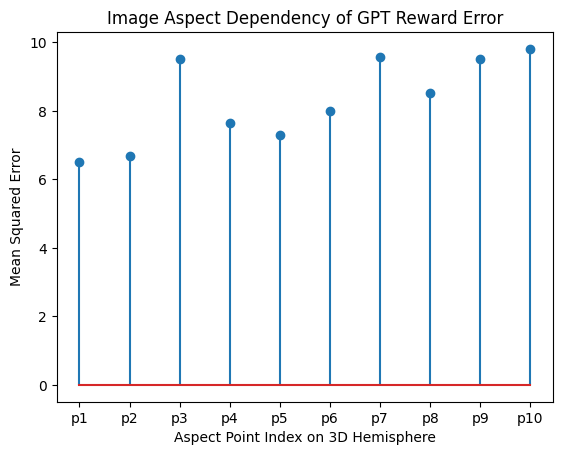

In [108]:

# Plot the aspect MSE array using a stem plot
plt.stem(aspect_mse_array)
plt.xlabel("Aspect Point Index on 3D Hemisphere")
plt.ylabel("Mean Squared Error")
plt.title("Image Aspect Dependency of GPT Reward Error")

plt.xticks(range(len(points)), points)
plt.show()
